In [221]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from utils import visualize_optimizer
from checker import test_optimizer

# Laboratorium 8. Optymalizatory

Notebook jest luźno wzorowany na [przeglądzie Sebastiana Rudera](https://ruder.io/optimizing-gradient-descent/index.html).

Państwa dzisiejszym zadaniem będzie zaimplementowanie najpopularniejszych optymalizatorów stosowanych w uczeniu maszynowym.

Każda z implementowanych przez Państwa klas dziedziczy po klasie `Optimizer`, w której gotowe są już pewne funkcjonalności. Państwa zadanie to przeładowanie metody `step` (oraz naturalnie dodawanie wymaganych rzeczy do konstruktora).

Ogólne uwagi do zadań:
* Proszę zwracać uwagę przy zmienianiu parametrów z środku optimizera, tak aby faktycznie je zmieniać, *hint*: `tensor.data` oraz patrz poniższa impelemtacja `GradientDescent`.
* Kolejność wzorów w sekcjach "Update" kolejnych metod jest jednocześnie zalecaną kolejnością implementacji.



In [222]:
from typing import List

class Optimizer:
    """Base class for each optimizer"""
    
    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params
    
    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

                
class GradientDescent(Optimizer):
    
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
    
    def step(self):
        for param in self.params:
            # actually change the values in the param
            param.data = param.data - self.learning_rate * param.grad
            
            # if you change the above line for this shorter version it will still work
            # however the plotting will be buggy due to the way python handles references
            # param.data -= self.learning_rate * param.grad

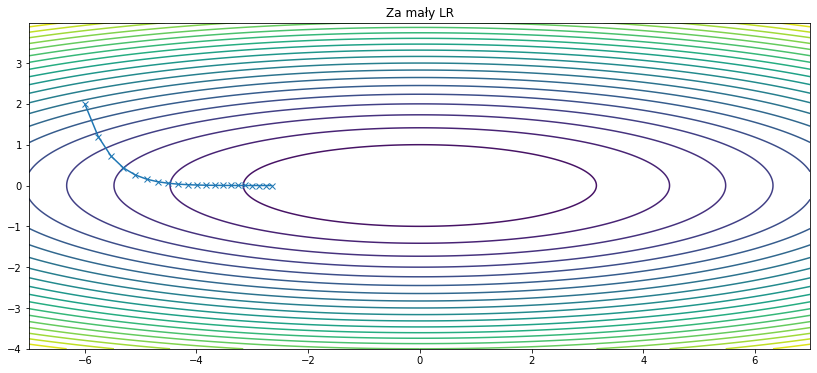

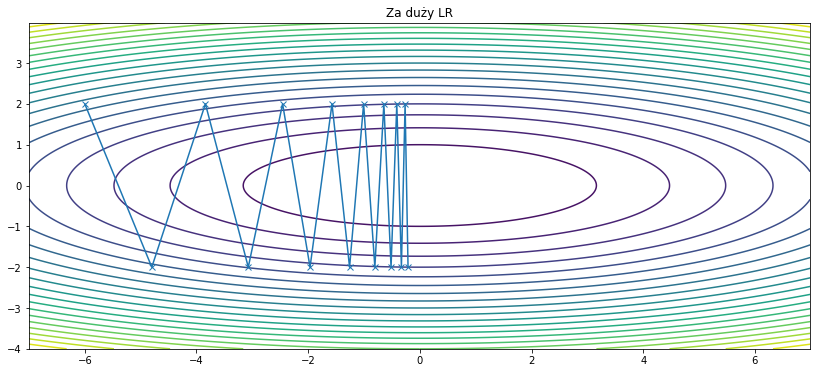

In [223]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title='Za mały LR')
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title='Za duży LR')

## Momentum (1 pkt.)
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Momentum (zawsze < 1, typowo 0.9)

### Update
Zmiany dokonywane są na podstawie wektora "pędu" (ang. *momentum*) $\Delta$, który rośnie jeżeli dokonujemy zmian w tym samym kierunku.

<font size="+2"> $$ \Delta_{t+1} = \gamma  \Delta_{t} + \eta \nabla_\theta \mathcal{L}(\theta_t) $$ </font><br>
<font size="+2"> $$ \theta_{t+1} = \theta_{t} - \Delta_{t+1} $$ </font>

#### Uwagi
* $\Delta_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.

In [224]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.deltas = [torch.zeros(thet.size()[0]) for thet in self.params]
        
        
        
    
    def step(self):
         for i in range(len(self.params)):
            self.deltas[i] = self.gamma * self.deltas[i] + self.learning_rate * self.params[i].grad
            self.params[i].data = self.params[i].data - self.deltas[i]
            

In [225]:

test_optimizer(Momentum)


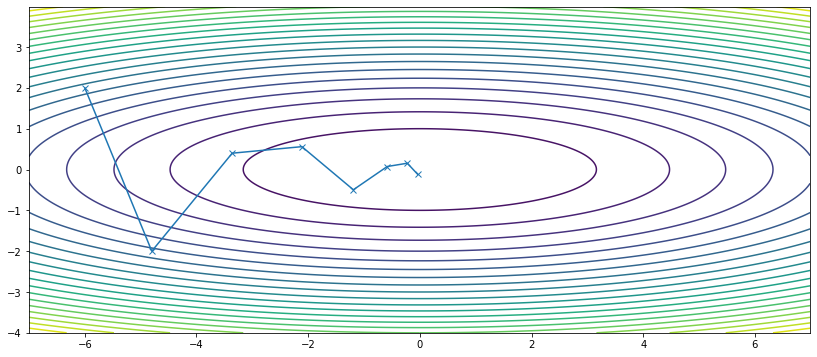

In [226]:
visualize_optimizer(Momentum, n_steps=7, learning_rate=0.5, gamma=0.4)

## Adagrad  (1 pkt.)
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
W każdym korku adaptujemy stałą uczenia $\eta$ dla każdego z wymiarów wag na podstawie sumy kwadratów dotychczasowych gradientów.

<font size="+2"> $$ \displaystyle  G_t = \sum_{i = 1}^{t} \big(\nabla_\theta \mathcal{L}(\theta_i)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



<font size="+0"> gdzie $G_t$ to suma kwadratów gradientów $\nabla_\theta \mathcal{L}(\theta_i)^2$ dla kroków $i = 1, .., t$ </font>

##### Uwagi
* $G_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [231]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Gt = [torch.zeros(thet.size()[0]) for thet in self.params]
        
    def step(self):
        for i in range(len(self.params)):
            self.Gt[i] = self.Gt[i] + self.params[i].grad**2
            self.params[i].data = self.params[i].data - self.learning_rate/torch.sqrt(self.Gt[i] + self.epsilon) * self.params[i].grad
        

In [235]:
test_optimizer(Adagrad)

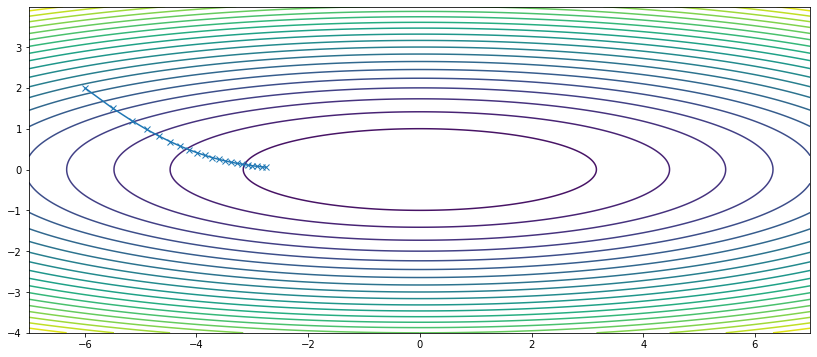

In [236]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=0.5, epsilon=1e-8)

## RMSProp  (1 pkt.)
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
Analogicznie dla algorytmu *Adagrad* adaptujemy stałą uczenia, lecz tym razem zamiast sumy, robimy to średnią kroczącą ze współczynnikiem $\gamma$.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



gdzie $H_t$ to średnia krocząca kwadratów gradientów $(\nabla_\theta \mathcal{L}(\theta_t))^2$ z kroków $0, 1, ..., t$ ze współczynnikiem $\gamma$.

#### Uwagi
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [247]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.H = [torch.zeros(thet.size()[0]) for thet in self.params]

    def step(self):
        for i in range(len(self.params)):
            self.H[i] = self.gamma * self.H[i] + (1-self.gamma) * self.params[i].grad**2
            self.params[i].data = self.params[i].data - self.learning_rate/torch.sqrt(self.H[i] + self.epsilon) * self.params[i].grad
            

In [248]:
test_optimizer(RMSProp)

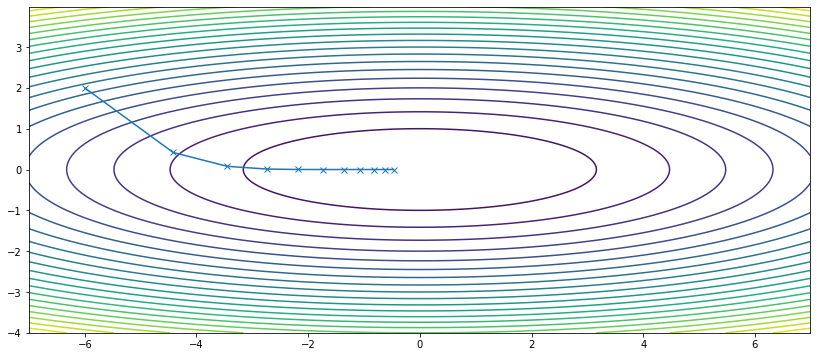

In [249]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

## Adadelta  (2 pkt.)
Hiperparametry:
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 oraz rozpoczęcia uczenia (typowo $10^{-8}$ do $10^{-2}$)

### Update
Eliminujemy stałą uczenia $\eta$ i sprawiamy, że "prędkość" poprawek jest podobna do faktycznych poprawek uzależniając krok uczenia od średniej kroczącej poprzednich poprawek.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \Delta_{t+1} = \frac{\sqrt{D_{t} + \epsilon}}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \Delta_{t+1} $$ </font>

<font size="+2"> $$ D_{t+1} = \gamma D_{t} + (1 - \gamma) \Delta_{t+1}^2 $$ </font>

#### Uwagi:
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $D_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [252]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon

        self.H = [torch.zeros(thet.size()[0]) for thet in self.params]
        self.D = [torch.zeros(thet.size()[0]) for thet in self.params]
        
    def step(self):
        for i in range(len(self.params)):
            self.H[i] = self.gamma * self.H[i] + (1-self.gamma) * self.params[i].grad**2
            delta = torch.sqrt(self.D[i]+self.epsilon)/torch.sqrt(self.H[i] + self.epsilon) * self.params[i].grad
            self.params[i].data = self.params[i].data - delta
            self.D[i] = self.gamma * self.D[i] + (1-self.gamma) * delta**2
        

In [253]:
test_optimizer(Adadelta)

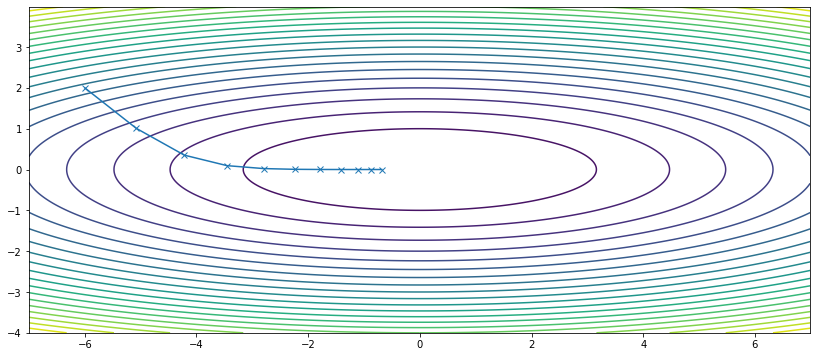

In [254]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1)

## Adam (2 pkt.)

Hiperparametry:
* $\eta$ - Learning Rate (typowo 0.001)
* $\beta_1$ - współczynnik średniej kroczącej pierwszego momentu (typowo 0.9)
* $\beta_2$ - współczynnik średniej kroczącej drugiego momentu (typowo 0.999)
* $\epsilon$ - zapobiega dzieleniu przez zero (typowo $10^{-8}$)

### Update
Adaptujemy gradient dwiema średnimi kroczącymi, pierwszego $m$ i drugiego $v$ momentu. Na początku uczenia te średnie są bardzo zbiasowane do 0, stąd wprowadzane są poprawka $\hat{m}$ i $\hat{v}$, im dalej w procesie uczenia, tym te poprawki wprowadzają mniejsze zmiany.  

<font size="+2"> $$ m_{t+1} = \beta_1 m_{t} + (1 - \beta_1)  \nabla_\theta \mathcal{L}(\theta_t) $$ </font>
<font size="+2"> $$ v_{t+1} = \beta_2 v_{t} + (1 - \beta_2)  \big( \nabla_\theta \mathcal{L}(\theta_t) \big)^2 $$ </font>
<br>
<font size="+2"> $$  \hat{m} = \frac{m_{t+1}}{1 - \beta_1^{(t+1)}} $$ </font><br>
<font size="+2"> $$  \hat{v} = \frac{v_{t+1}}{1 - \beta_2^{(t+1)}} $$ </font>
<br>
<font size="+2"> $$ \theta_{t+1} = \theta_t - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} $$ </font>

#### Uwagi
* $m_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $v_0 = \mathbf{0}$, wymiar taki sam jak $\theta$. 
* $\beta_1^{(t+1)}$ oraz $\beta_2^{(t+1)}$ to potęgowania.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.


In [334]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
    
        self.m = [torch.zeros(thet.size()[0]) for thet in self.params]
        self.v = [torch.zeros(thet.size()[0]) for thet in self.params]
        self.t = 0
        
    def step(self,):
        for i in range(len(self.params)):
            self.m[i] = self.beta1 * self.m[i] + (1-self.beta1) * self.params[i].grad
            self.v[i] = self.beta2 * self.v[i] + (1-self.beta2) * self.params[i].grad**2
            m_ = self.m[i]/(1-self.beta1**(self.t+1))
            v_ = self.v[i]/(1-self.beta2**(self.t+1))
            self.params[i].data = self.params[i].data - self.learning_rate * (m_/(torch.sqrt(v_) + self.epsilon))
        
        

In [336]:
test_optimizer(Adam)

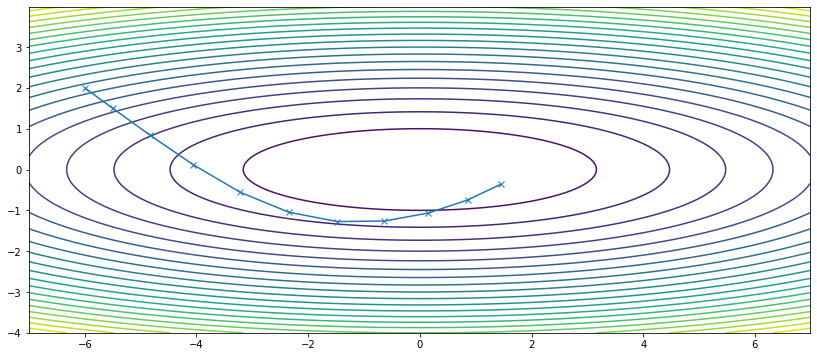

In [337]:
visualize_optimizer(Adam, n_steps=10, learning_rate=0.5, beta1=0.9, beta2=0.999, epsilon=1e-8)